In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle
from scipy.signal import hilbert

In [3]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [4]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

# load the classifier results
sweepresults = xr.open_dataset(
    os.path.join(datafolder, "bon_03_06_cv_classifier_clusterless_results.nc")
)

# load the data with pickle
with open(os.path.join(datafolder, "bon_03_06_data.pkl"), "rb") as f:
    data = pickle.load(f)

# get time slice
t = data["position_info"].index / np.timedelta64(1, "s")

Text(0.5, 1.0, 'LFP0 with zero phase marked')

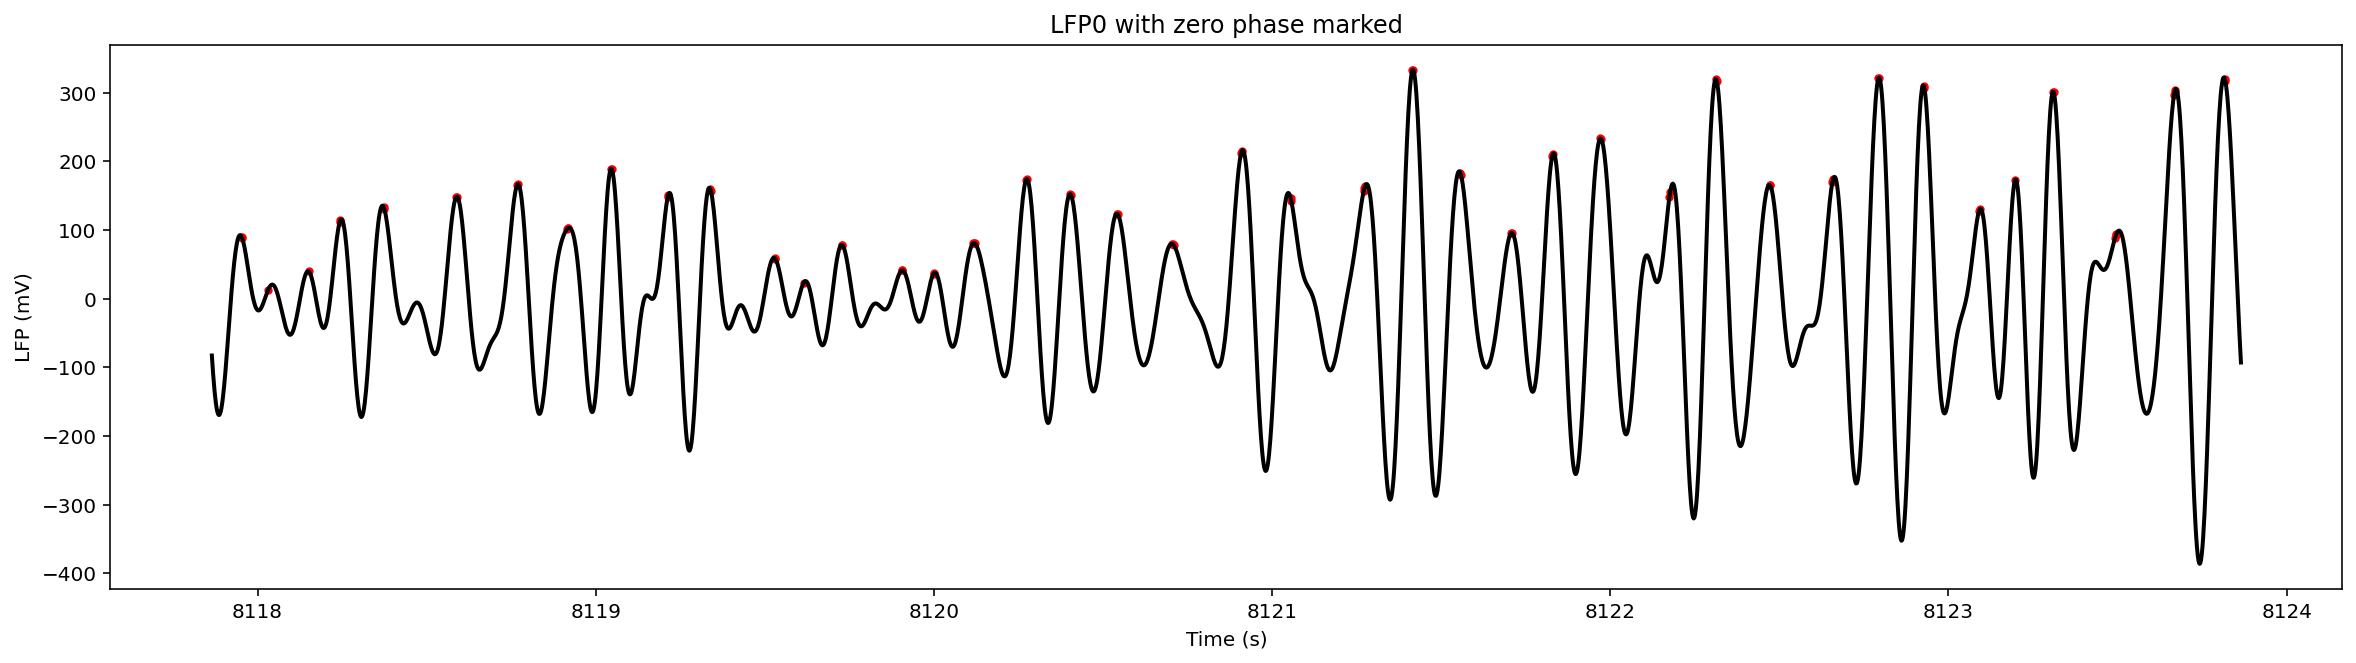

In [5]:
ind = 0
lfp = (
    data["lfps"]
    .reset_index(drop=True)
    .set_index(data["lfps"].index / np.timedelta64(1, "s"))
)
# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

time_slice = slice(t.min() + 360.85, t.min() + 366.85)

# find the zerp phase of lfp0 with hilbert transform

analytic_signal = hilbert(lfp0[time_slice].values.squeeze())
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * 500
# pad the instantaneous_frequency with 0
instantaneous_frequency = np.insert(instantaneous_frequency, 0, 0)
# wrap the instantaneous_phase to -pi and pi
instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
# find phase of 0 and mark all of them as a red point on the plot
zero_phase = np.where(
    np.logical_and(instantaneous_phase > -0.1, instantaneous_phase < 0.1)
)[0]

# plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(lfp.loc[time_slice].index.values, lfp0[time_slice], color="black", linewidth=2)
ax.scatter(
    lfp.loc[time_slice].index.values[zero_phase],
    lfp0[time_slice].values[zero_phase],
    color="red",
    s=10,
)
ax.set_ylabel("LFP (mV)")
ax.set_xlabel("Time (s)")
ax.set_title("LFP0 with zero phase marked")

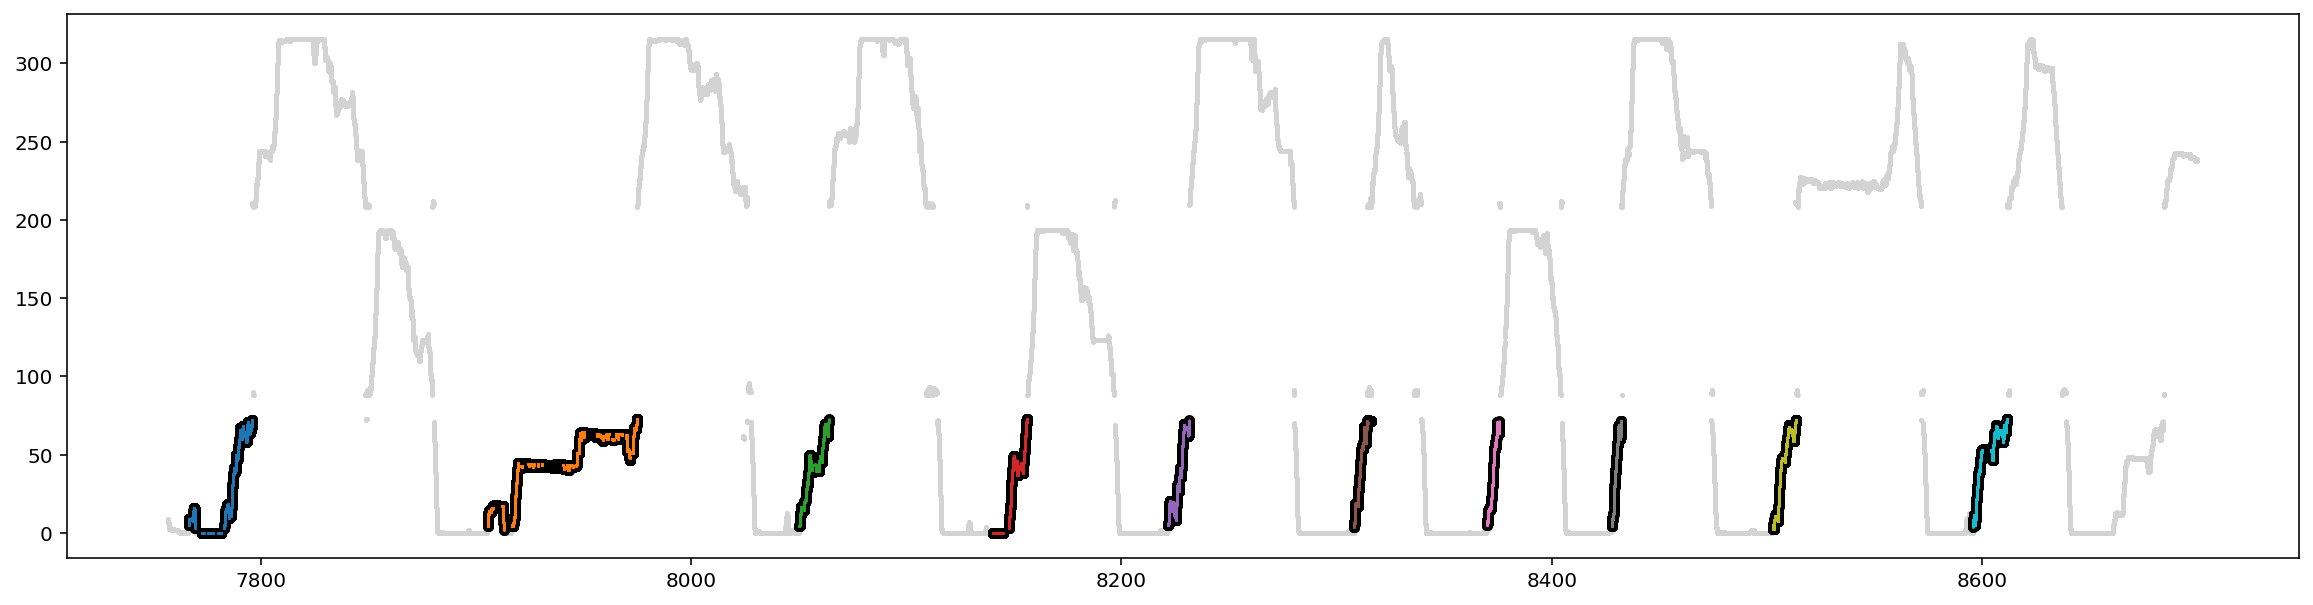

In [6]:
# extract position informtion
position_info = data["position_info"]

# extract position_info with only 'outbound' in task column, as well as 'Center Arm' in arm_name column

outbound_position_info = position_info[
    (position_info.task == "Outbound") & (position_info.arm_name == "Center Arm")
]

# select speed more than 10 cm/s in outbound_position_info
outbound_position_info_running = outbound_position_info[
    outbound_position_info.speed > 4
]

alltime = outbound_position_info_running.index / np.timedelta64(1, "s")
# split alltime into blocks if successive time difference is larger than 1s
alltime_split = np.split(alltime, np.where(np.diff(alltime) > 20)[0] + 1)

fig, ax = plt.subplots(figsize=(20, 5))

# plot all the position_info with very light grey dots
ax.scatter(
    position_info.index / np.timedelta64(1, "s"),
    position_info.linear_position,
    s=1,
    color="lightgrey",
)

# mark the outbound position with orange dots
ax.scatter(
    outbound_position_info.index / np.timedelta64(1, "s"),
    outbound_position_info.linear_position,
    s=20,
    c="black",
)

# for each block of alltime_split, plot the running outbound position with a different color
for i in range(len(alltime_split)):
    ax.scatter(
        alltime_split[i],
        outbound_position_info_running.reset_index()
        .set_index(alltime)
        .loc[alltime_split[i]]
        .linear_position,
        s=0.1,
    )

# #mark the running outbound position with lightblue dots
# ax.scatter(
#     outbound_position_info_running.index / np.timedelta64(1, "s"),
#     outbound_position_info_running.linear_position,
#     s=0.1,
#     c="lightblue",
# )

In [7]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.05)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)
    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

slice(8308.0828, 8314.8248, None)


Text(0.5, 1.0, 'LFP0 with zero phase marked')

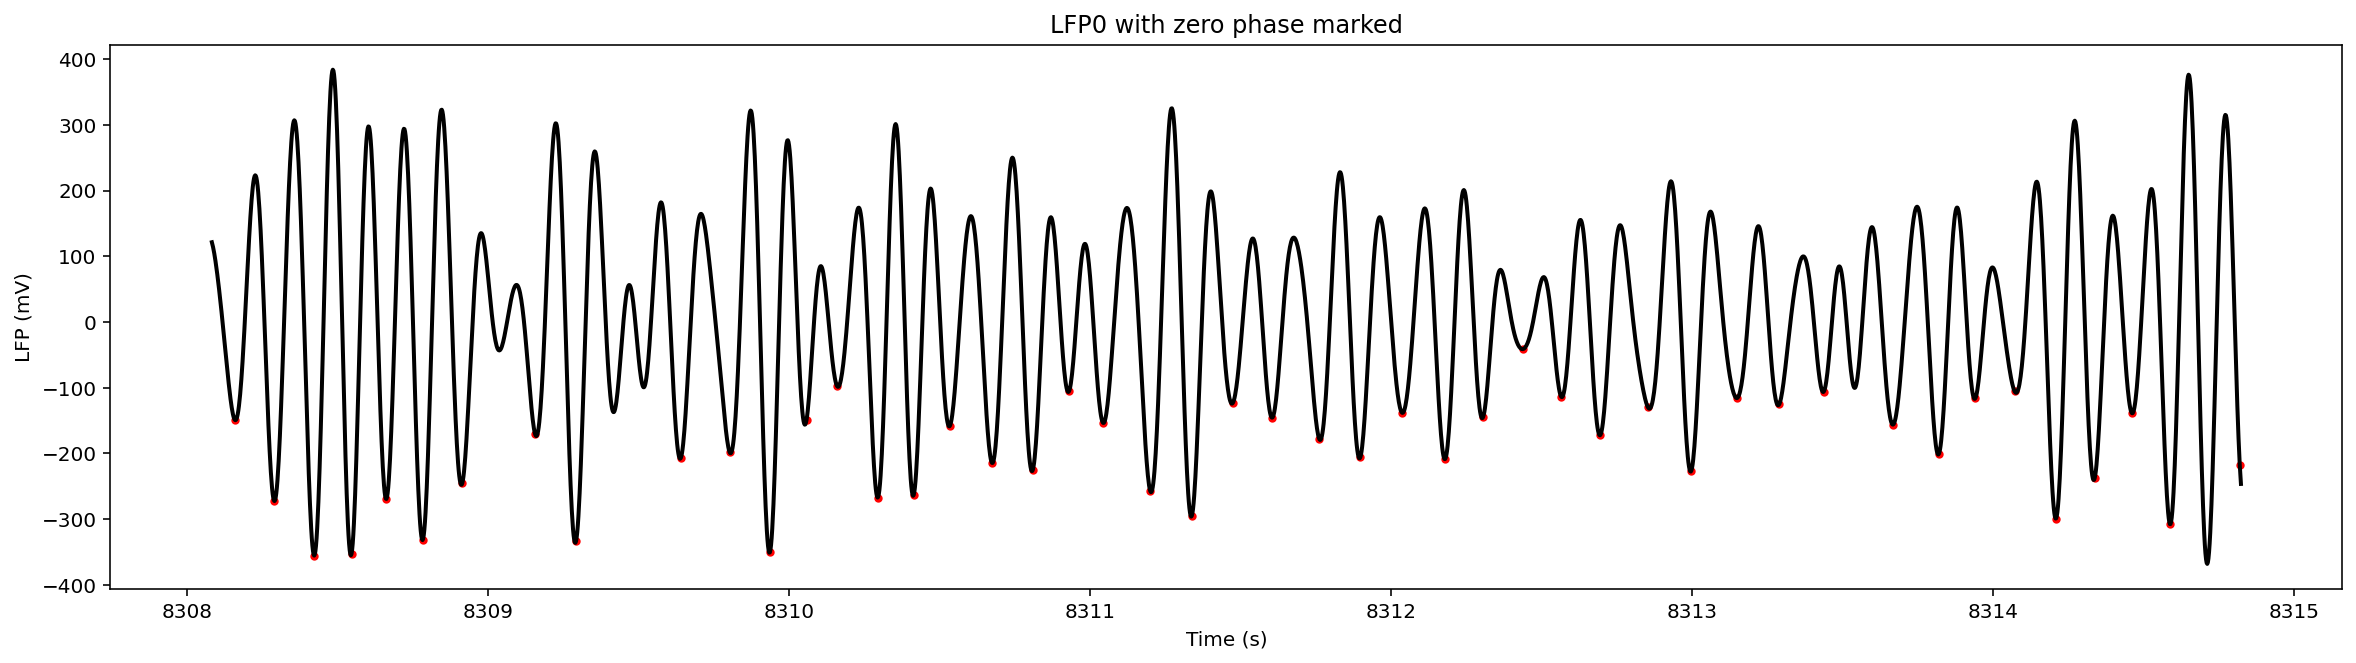

In [8]:
time_slice = slice(alltime_split[5][0], alltime_split[5][-1])
print(time_slice)

lfp_run_i = lfp0[time_slice]

zero_phase_index = get_zero_phase(lfp_run_i)


# plot the lfp0 with zero phase marked
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(lfp_run_i.index.values, lfp_run_i.values.squeeze(), color="black", linewidth=2)
ax.scatter(
    lfp_run_i.index.values[zero_phase_index],
    lfp_run_i.values.squeeze()[zero_phase_index],
    color="red",
    s=10,
)
ax.set_ylabel("LFP (mV)")
ax.set_xlabel("Time (s)")
ax.set_title("LFP0 with zero phase marked")

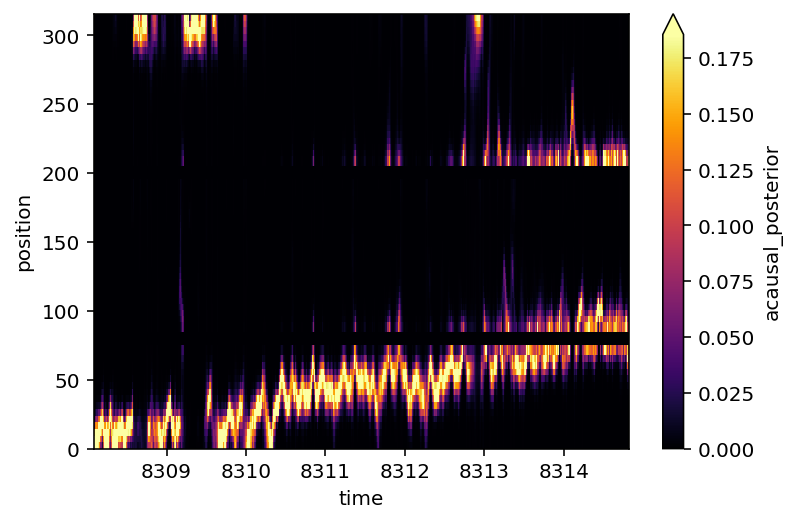

In [9]:
# get
sweepresults.acausal_posterior.sum("state").sel(time=time_slice).plot(
    x="time",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
)

(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)
(175, 63)


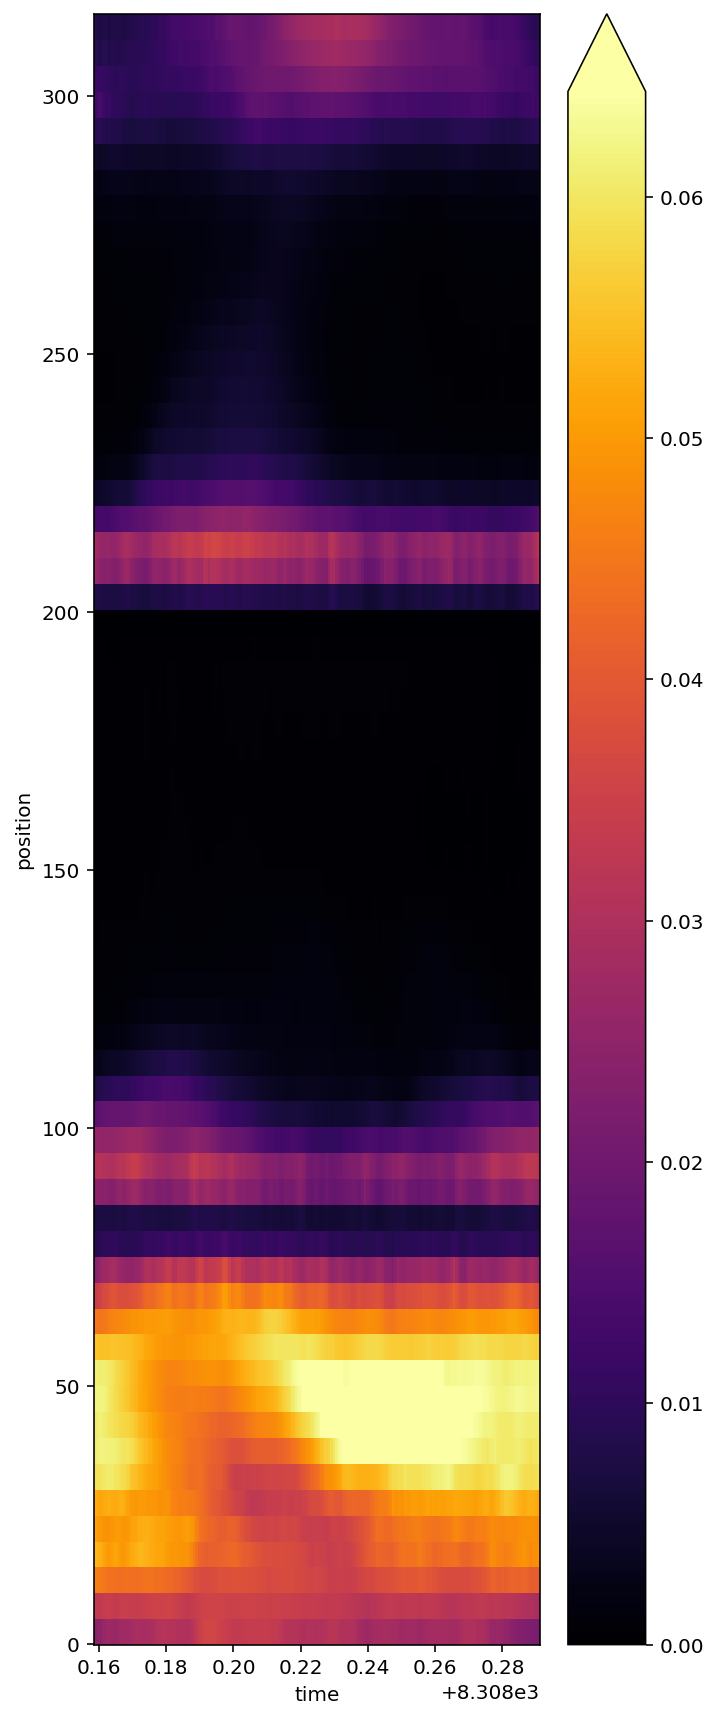

In [10]:
time_bins = lfp_run_i.index.values[zero_phase_index]

posterior_ = sweepresults.acausal_posterior.sum("state").sel(time=time_slice)

# get the poterior in each time bin
ALL_POSTERIOR = []
width = []
height = []
for i in range(len(time_bins) - 1):
    posterior_i = posterior_.sel(time=slice(time_bins[i], time_bins[i + 1]))
    width.append(posterior_i.shape[0])
    height.append(posterior_i.shape[1])
    ALL_POSTERIOR.append(posterior_i)

maxwidth = max(width)
maxheight = max(height)
# for each array in the ALL_POSTERIOR, interpolate it to the same size which is the maxwidth and maxheight
# do in a step by step way
ALL_POSTERIOR_INTERPOLATED = []
for i in range(len(ALL_POSTERIOR)):
    posterior_i = ALL_POSTERIOR[i]
    posterior_i = posterior_i.interp(
        time=np.linspace(posterior_i.time.min(), posterior_i.time.max(), maxwidth)
    )
    posterior_i = posterior_i.interp(
        position=np.linspace(
            posterior_i.position.min(), posterior_i.position.max(), maxheight
        )
    )
    ALL_POSTERIOR_INTERPOLATED.append(posterior_i)
    print(posterior_i.shape)

# average all the posterior and plot the mean posterior
mean_posterior = np.mean(
    np.stack([posterior_i.values for posterior_i in ALL_POSTERIOR_INTERPOLATED]), axis=0
)
mean_posterior = xr.DataArray(
    mean_posterior,
    coords=[ALL_POSTERIOR_INTERPOLATED[0].time, ALL_POSTERIOR_INTERPOLATED[0].position],
    dims=["time", "position"],
)
# plot with figsize=(5, 15)
mean_posterior.plot(
    x="time",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(5, 15),
)

In [11]:
def get_instantaneous_phase(filtered_lfp):
    """
    get the instantaneous phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi

    return instantaneous_phase

In [ ]:
time_slice = slice(alltime_split[8][0], alltime_split[8][-1])
posterior_ = sweepresults.acausal_posterior.sum("state").sel(time=time_slice)

lfp_run_i = lfp0[time_slice]
phase = get_instantaneous_phase(lfp_run_i)

# group posterior_ by phase
# first get the phase bins
phase_bins = np.linspace(-np.pi, np.pi, 40)
# then for each phase_bin, get the posterior in that phase bin
ALL_POSTERIOR = []
for i in range(len(phase_bins) - 1):
    # get phases index belong to this phase bin
    phase_i_index = np.where((phase > phase_bins[i]) & (phase < phase_bins[i + 1]))[0]
    # select time_index according to phase_i index
    time_index = posterior_.time.values[phase_i_index]
    # select posterior according to time_index
    posterior_i = posterior_.sel(time=time_index)
    # average the posterior_i along time axis
    posterior_i = posterior_i.mean("time")
    ALL_POSTERIOR.append(posterior_i.values)

# change the ALL_POSTERIOR to   xr.DataArray
ALL_POSTERIOR = xr.DataArray(
    np.stack(ALL_POSTERIOR),
    coords=[np.linspace(-np.pi, np.pi, 39), posterior_.position],
    dims=["phase", "position"],
)

# plot the ALL_POSTERIOR
ALL_POSTERIOR.plot(
    x="phase",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(2, 4),
)

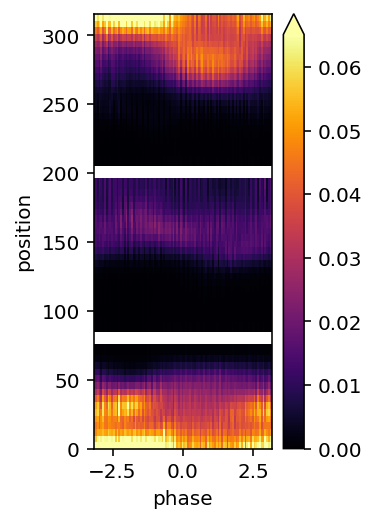

In [100]:
is_running = data["position_info"].speed > 30
t = data["position_info"].index / np.timedelta64(1, "s")
# get the position_info of running
posterior_ = sweepresults.acausal_posterior.sum("state", skipna=False).sel(
    time=data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

is_running_time = (
    data["position_info"].reset_index(drop=True).set_index(t).index[is_running]
)

# get the lfp0 withis_running_time ==True
lfp_run_i = lfp0.loc[is_running_time]

phase = get_instantaneous_phase(lfp_run_i)

# group posterior_ by phase
# first get the phase bins
phase_bins = np.linspace(-np.pi, np.pi, 100)
# then for each phase_bin, get the posterior in that phase bin
ALL_POSTERIOR = []
for i in range(len(phase_bins) - 1):
    # get phases index belong to this phase bin
    phase_i_index = np.where((phase > phase_bins[i]) & (phase < phase_bins[i + 1]))[0]
    # select time_index according to phase_i index
    time_index = posterior_.time.values[phase_i_index]
    # select posterior according to time_index
    posterior_i = posterior_.sel(time=time_index)
    # average the posterior_i along time axis
    posterior_i = posterior_i.mean("time")
    ALL_POSTERIOR.append(posterior_i.values)

# change the ALL_POSTERIOR to   xr.DataArray
ALL_POSTERIOR = xr.DataArray(
    np.stack(ALL_POSTERIOR),
    coords=[np.linspace(-np.pi, np.pi, 99), posterior_.position],
    dims=["phase", "position"],
)

# plot the ALL_POSTERIOR
ALL_POSTERIOR.plot(
    x="phase",
    y="position",
    robust=True,
    cmap="inferno",
    vmin=0.0,
    figsize=(2, 4),
)

In [96]:
lfp_run_i.shape

(12237, 1)

In [98]:
phase

array([2.24808439, 2.68213286, 2.72118158, ..., 1.36328305, 1.38277287,
       1.49196454])

In [90]:
data["position_info"].reset_index(drop=True).set_index(t).index[is_running]

Float64Index([7757.0148, 7757.0168, 7757.0188, 7757.0208, 7757.0228, 7757.0248,
              7757.0268, 7757.0288, 7757.0308, 7757.0328,
              ...
              8696.7268, 8696.7288, 8696.7308, 8696.7328, 8696.7348, 8696.7368,
              8696.7388, 8696.7408, 8696.7428, 8696.7448],
             dtype='float64', name='time', length=204164)

In [64]:
is_running.shape

(471495,)

In [63]:
sweepresults.acausal_posterior.sum("state", skipna=False)

<xarray.DataArray 'acausal_posterior' (time: 471495, position: 63)>
array([[0.100223  , 0.08989098, 0.07594089, ..., 0.01226297, 0.01238076,
        0.01257046],
       [0.20345961, 0.18528609, 0.15403023, ..., 0.00195541, 0.00168622,
        0.0015046 ],
       [0.23168485, 0.20309833, 0.16351185, ..., 0.00187866, 0.00179593,
        0.00175512],
       ...,
       [0.00361879, 0.00367568, 0.00376216, ..., 0.01487433, 0.01523237,
        0.01540818],
       [0.00423505, 0.00427492, 0.00434979, ..., 0.01494605, 0.01550857,
        0.01581107],
       [0.00462248, 0.00454407, 0.0045185 , ..., 0.01503593, 0.01578438,
        0.01636648]])
Coordinates:
  * time      (time) float64 7.757e+03 7.757e+03 7.757e+03 ... 8.7e+03 8.7e+03
  * position  (position) float64 2.433 7.3 12.17 17.03 ... 303.8 308.6 313.4

In [65]:
time_slice

slice(8502.7168, 8513.6748, None)